In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import scipy

from sklearn.linear_model import Ridge

import child_poverty_iraq.data.load_data as ld
import child_poverty_iraq.models.train_model as tm
import child_poverty_iraq.models.evaluate_model as em
import child_poverty_iraq.models.predict_model as pm


# Load data

In [2]:
target = 'deprived_mod'

In [3]:
merged = pd.read_csv('../data/processed/20230918_adm1_mosaiks_pov_merged.csv')
merged.shape

(1033, 4031)

# Model

In [4]:
pred_amd1, model, model_details, performance = tm.train_model(merged, target=target, 
                                   model = Ridge(0.5),
                                   boxcox=True, pca_components=300, weight=25, plot=False)

print(performance)

y_train_pred = pred_amd1[pred_amd1['is_training']==1]['predictions']
y_train = pred_amd1[pred_amd1['is_training']==1][target]
y_test_pred = pred_amd1[pred_amd1['is_training']==0]['predictions']
y_test = pred_amd1[pred_amd1['is_training']==0][target]

Lambda: 2.69351856995555
{'r2_cv': 0.545411310822929, 'r2_cv_sd': 0.056300353689365555, 'r2_train': 0.8195883423048778, 'r2_test': 0.6830590802188325}


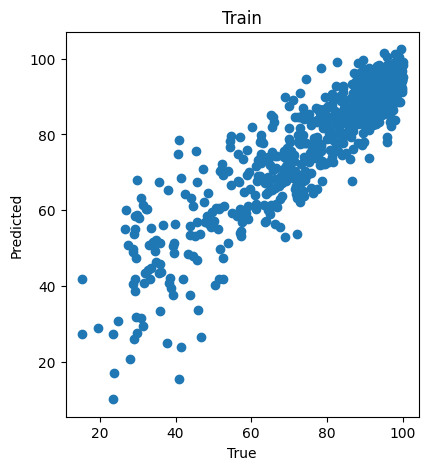

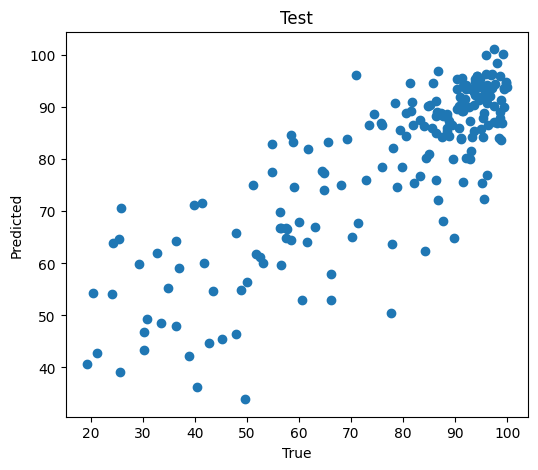

In [5]:
em.scatter_plot(y_train_pred, y_train, y_test, y_test_pred)

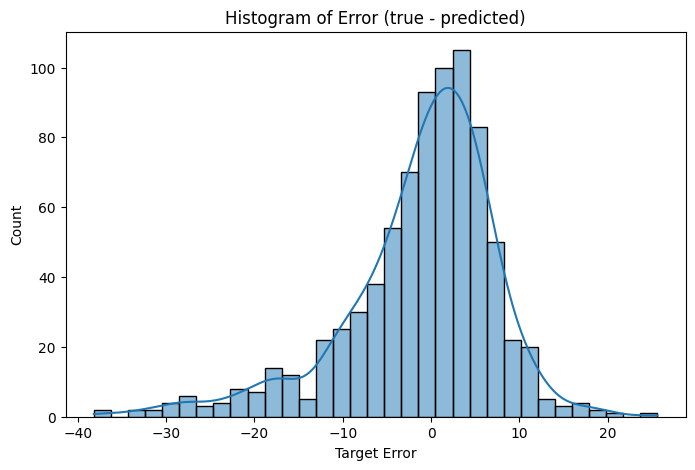

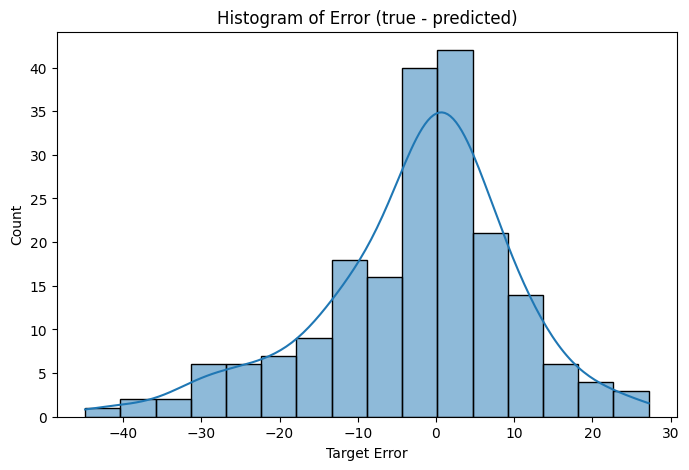

In [6]:
em.hist_errors(y_train_pred, y_train, y_test, y_test_pred)

The file '../data/external/geoBoundariesCGAZ_ADM0.topojson' exists.


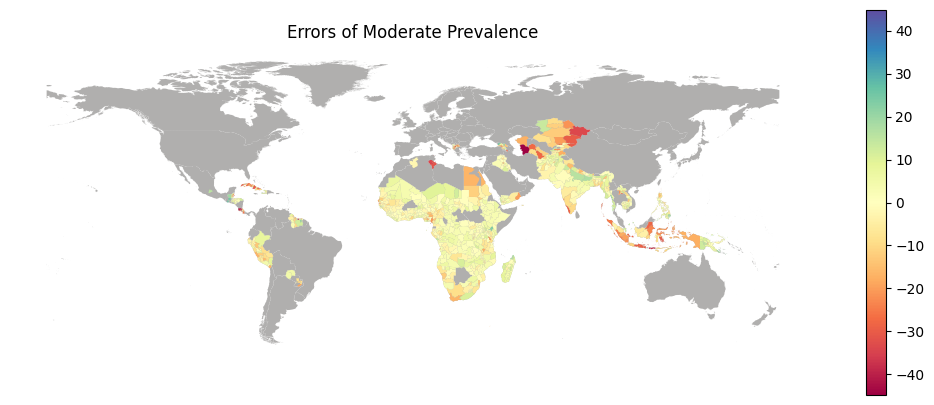

In [7]:
em.map_errors(pred_amd1, col_to_plot="target_error")

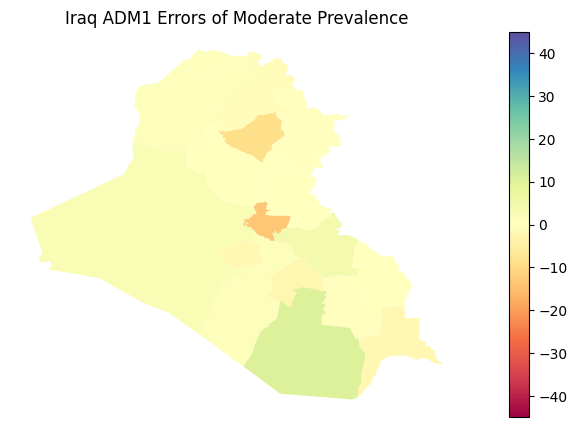

In [11]:
em.map_irq_error(pred_amd1, col_to_plot="target_error")


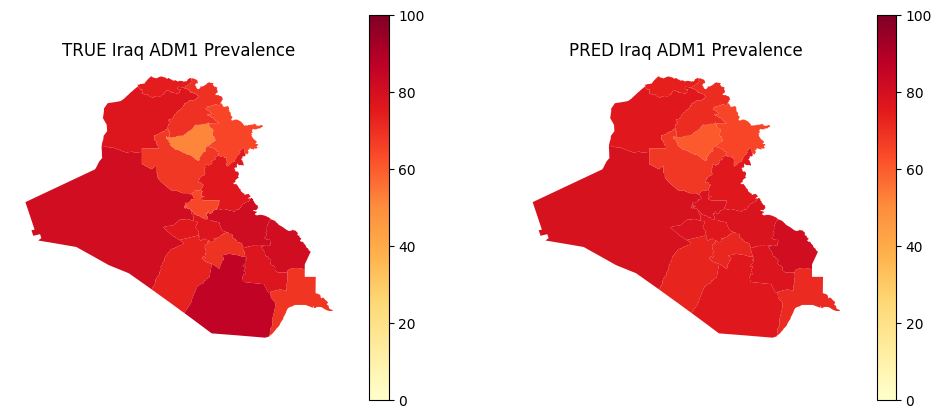

In [9]:
em.compare_irq_pred(pred_amd1, target, cmap="YlOrRd")

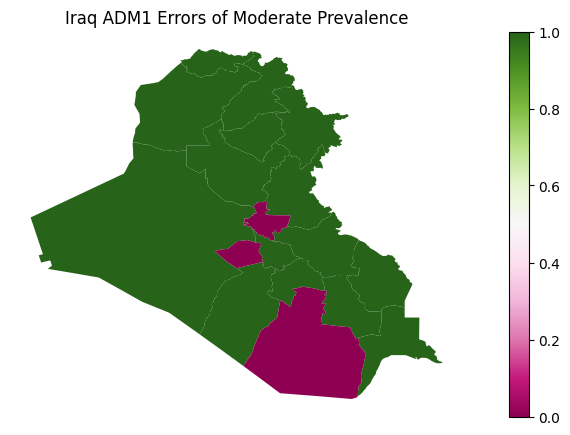

In [10]:
em.map_irq_training(pred_amd1)

# Predict

The file '../data/interim/IRQ_mosaiks_ADM2.csv' exists.
(101, 4002)
(101, 2)
(101, 4003)


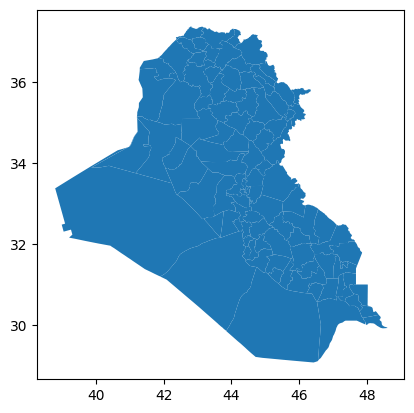

(101, 4003)


In [12]:
irq_adm2 = ld.adm2_for_country(cc='IRQ')
print(irq_adm2.shape)

In [13]:
irq_adm2['predictions'] = pm.predict_model(model, model_details, irq_adm2)

In [14]:
irq_adm2[irq_adm2['predictions'].isna()].shape

(0, 4004)

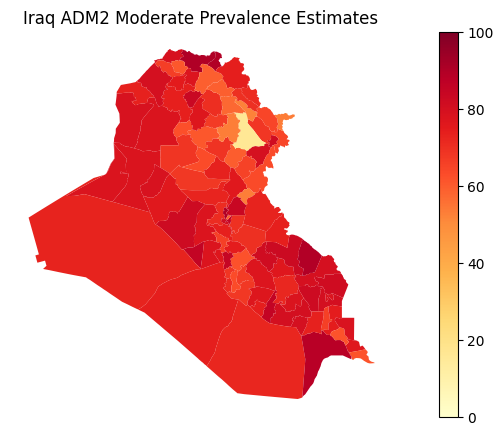

In [15]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot ADM2 prevalence estimate
irq_adm2.plot(ax=ax, column='predictions', cmap='YlOrRd', legend=True, vmin = 0, vmax= 100)

plt.title(f'Iraq ADM2 Moderate Prevalence Estimates')
plt.axis('off')
plt.show()

In [16]:
irq_01x01 = pd.read_csv('../data/interim/mosaiks_irq_01x01.csv')

# Create a geometry column with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(irq_01x01['lon'], irq_01x01['lat'])]

# Create a GeoDataFrame from the DataFrame and geometry
irq_01x01 = gpd.GeoDataFrame(irq_01x01, geometry=geometry, crs='EPSG:4326')  # Assuming WGS 84 coordinate reference system

print(irq_01x01.shape)

(4217, 4004)


In [17]:
irq_01x01['predictions'] = pm.predict_model(model, model_details, irq_01x01)

In [18]:
irq_01x01['predictions'].isna().sum()


184

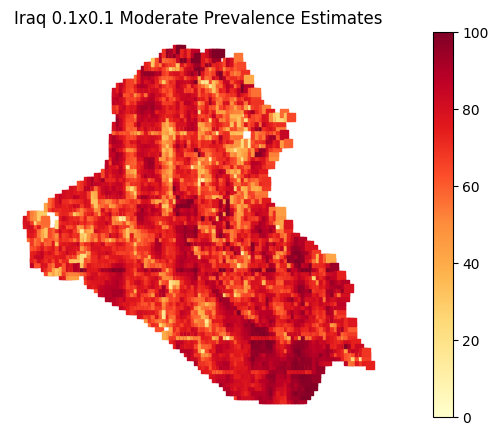

In [19]:
# Create a plot using matplotlib
fig, ax = plt.subplots(figsize=(12, 5)) #, dpi=200)

# Plot ADM2 prevalence estimate
irq_01x01.plot(ax=ax, column='predictions', cmap='YlOrRd', legend=True, vmin = 0, vmax= 100, marker = ',')

plt.title(f'Iraq 0.1x0.1 Moderate Prevalence Estimates')
plt.axis('off')
plt.show()